In [3]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering_shadows import render_rays, efficient_sm
from models.nerf import *

import metrics

from datasets import dataset_dict
from datasets.llff import *

torch.backends.cudnn.benchmark = True

img_wh = (64, 64)

def normalize_min_max(tensor, new_max=1.0, new_min=0.0):
     return (tensor - tensor.min())/(tensor.max() - tensor.min() + EPSILON)*(new_max - new_min) + new_min



In [4]:
from dotmap import DotMap
    
hparams = {
    'black_and_white': False, 
    'coords_trans': False, 
    'blur': -1, 
    'white_pix': -1, 
}
hparams = DotMap(hparams)
dataset = dataset_dict['efficient_sm'] \
          ('../../datasets/variable_light/results_200_bunny_var_light_fov50_sigma30/', 'val',
           img_wh=img_wh, hparams=hparams)

!ls ./logs-eval/NEW___SIGMA_Nimp_64_64x64_grad_on_light_LN_32_shadowmethod2/epoch\=10.ckpt

Training Image size: (64, 64)
Root Directory: 
-------------------------------
RESOLUTION OF THE ORIGINAL IMAGE IS SET TO 200
-------------------------------
------------
NOTE: self.hparams.coords_trans is set to False 
------------
'./logs-eval/NEW___SIGMA_Nimp_64_64x64_grad_on_light_LN_32_shadowmethod2/epoch=10.ckpt'


In [24]:
embedding_xyz = Embedding(3, 10)
embedding_dir = Embedding(3, 4)

nerf_coarse = NeRF()
nerf_fine = NeRF()

ckpt_path = './logs-eval/NEW___SIGMA_Nimp_64_64x64_grad_on_light_LN_32_shadowmethod2/epoch=10.ckpt'
# ckpt_path = "../nerf_pl-dev/ckpts/BUNNY_SIGMA10_128x128_sm2_smapper2d_run2_random_init/epoch=228.ckpt"
# ckpt_path = "../nerf_pl-dev/ckpts/BOX_SIGMA100_128x128_sm2_smapper2d/epoch=228.ckpt"


# ckpt_path = 'ckpts/exp2/epoch=05.ckpt'

# ckpt_path = 'ckpts/fern/epoch=29.ckpt'
# ckpt_path = 'ckpts/silica3_3/epoch=29.ckpt'

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

nerf_coarse.cuda().eval()
nerf_fine.cuda().eval();

In [25]:
models = [nerf_coarse, nerf_fine]
embeddings = [embedding_xyz, embedding_dir]

N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32*4
perturb =0
noise_std = 0
@torch.no_grad()
def f(rays):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        use_disp,
                        perturb,
                        noise_std,
                        N_importance=N_importance,
                        chunk=chunk, # chunk size is effective in val mode
                        white_back = True, 
                        were_gradients_computed=False)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [7]:
sample = dataset[1]
print(sample.keys())
render_poses = torch.stack([pose_spherical(angle, -60., 100.0) for angle in np.linspace(-180,180,40+1)[:-1]], 0)
rays = []
for p in range(render_poses.shape[0]):
    c2w = render_poses[p][:3, :4]
    print(c2w)
    hfov = dataset.meta['camera_angle_x'] * 180./np.pi
#     ppc = Camera(hfov, (h, w))
#     ppc.set_pose_using_blender_matrix(c2w, False)
#     all_ppc.extend([ppc]*h*w)
    rays_o, rays_d = get_rays(dataset.directions, c2w)
    r = torch.cat([rays_o, rays_d, 
                      dataset.near*torch.ones_like(rays_o[:, :1]),
                      dataset.far*torch.ones_like(rays_o[:, :1])],
                      1) # (H*W, 8)
    rays.append(r)
    break

    
# raise
rays = torch.cat(rays,0).cuda()
# rays = sample['rays'].cuda()


t = time.time()
results = f(rays)
torch.cuda.synchronize()
print(time.time()-t)

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])


NameError: name 'pose_spherical' is not defined

In [20]:
results, results['opacity_fine'].shape, 

(defaultdict(list,
             {'depth_coarse': tensor([ 98.7761,  99.4826, 100.4918,  ..., 123.7902, 123.4308, 122.9663],
                     device='cuda:0'),
              'opacity_coarse': tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0'),
              'disp_map_coarse': tensor([0.0101, 0.0101, 0.0100,  ..., 0.0081, 0.0081, 0.0081], device='cuda:0'),
              'depth_fine': tensor([100.8240, 100.5805, 101.8369,  ..., 132.1337, 132.0524, 128.4944],
                     device='cuda:0'),
              'opacity_fine': tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0'),
              'disp_map_fine': tensor([0.0099, 0.0099, 0.0098,  ..., 0.0076, 0.0076, 0.0078], device='cuda:0')}),
 torch.Size([4096]))

torch.Size([4096])
PSNR inf


/home/gridsan/ktiwary/.conda/envs/nerf_pl/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


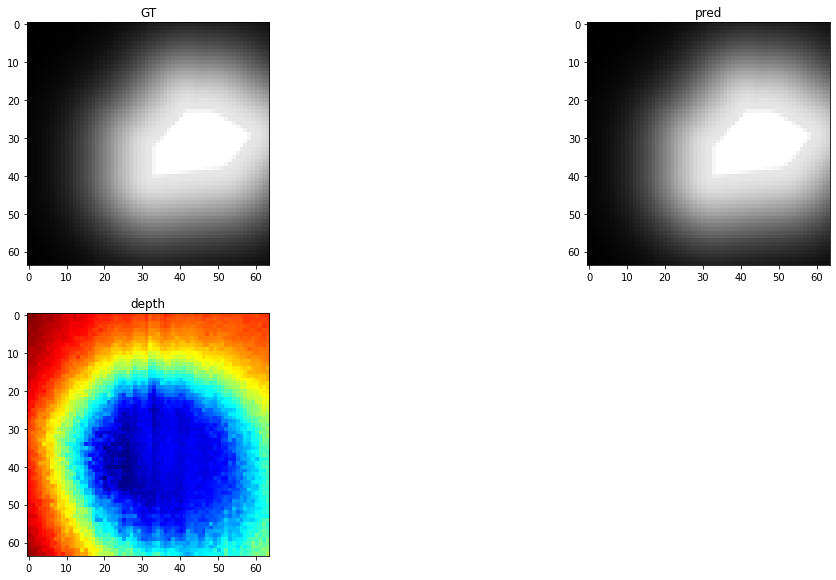

In [21]:
img_gt = torch.tensor(sample['rgbs']).view(img_wh[1], img_wh[0], 3)
img_pred = img_gt # results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
print(results['opacity_fine'].shape)



alpha_pred = results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])
print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.10032510757446289


/home/gridsan/ktiwary/.conda/envs/nerf_pl/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


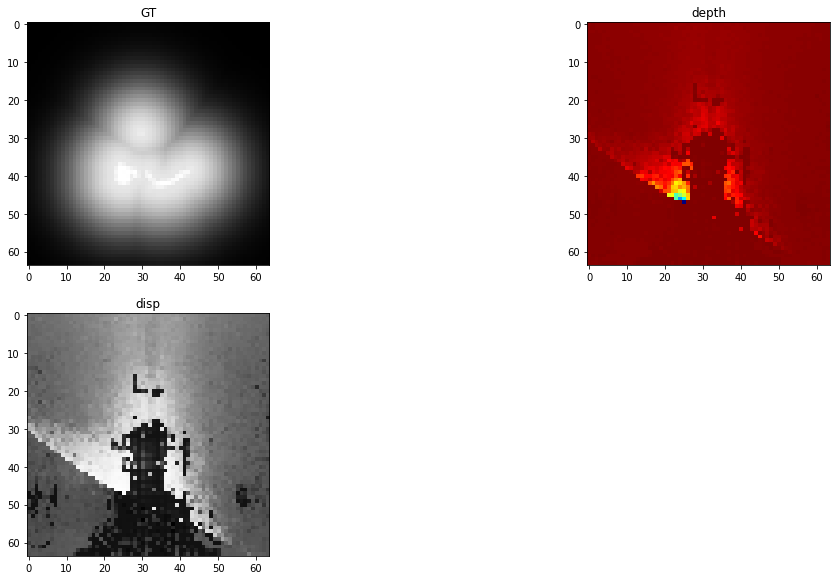

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.0969550609588623
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


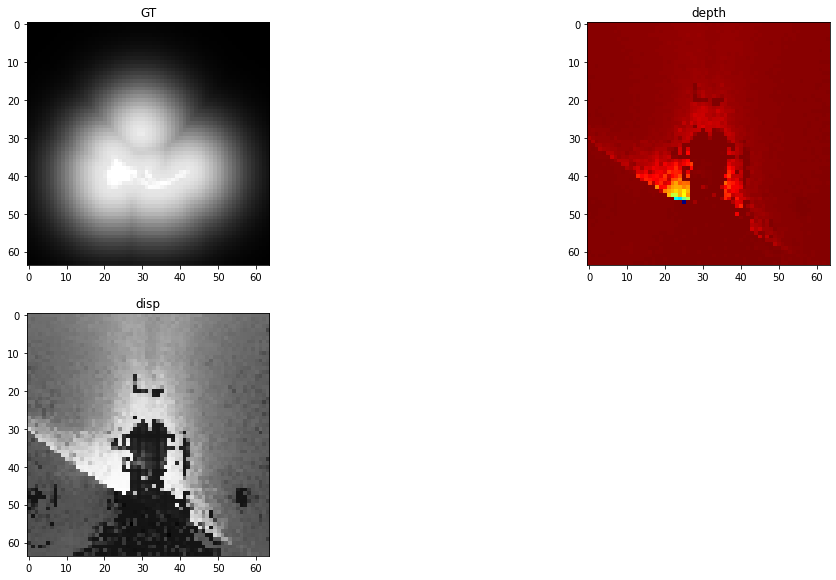

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09707164764404297
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


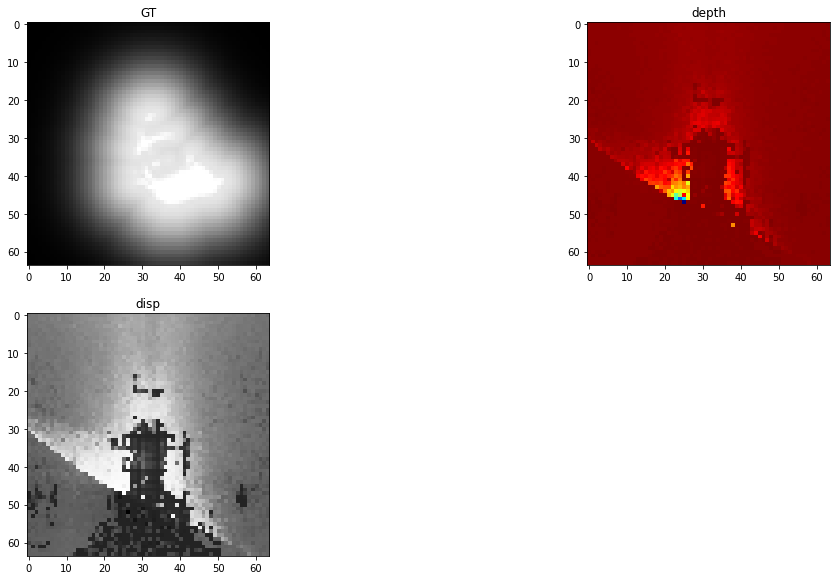

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09579110145568848
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


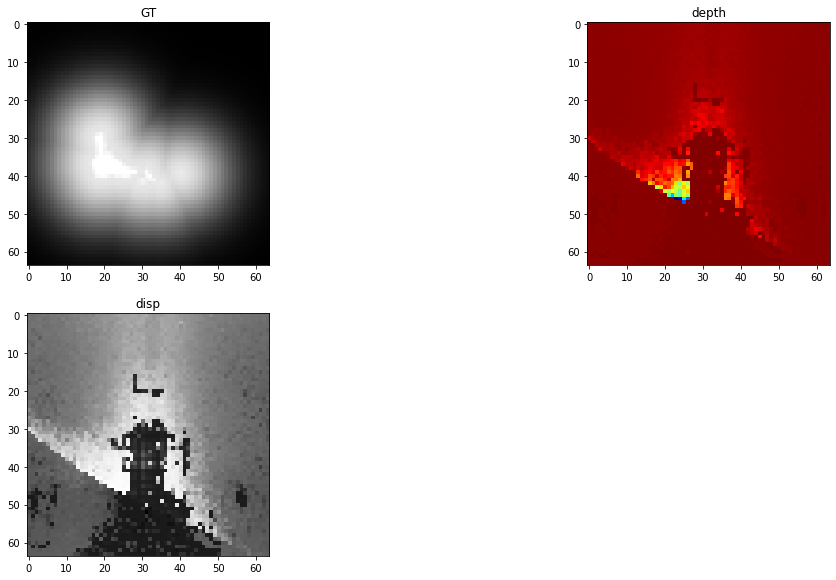

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09594368934631348
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


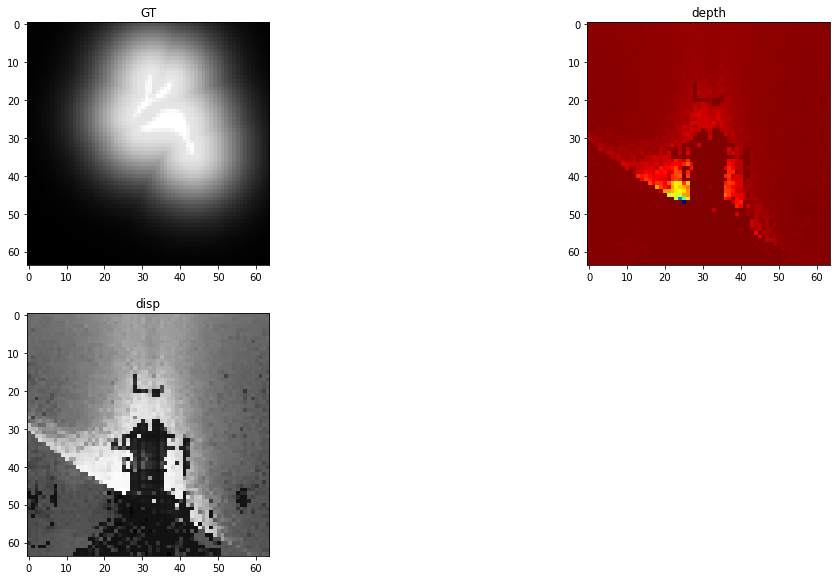

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.0957791805267334
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


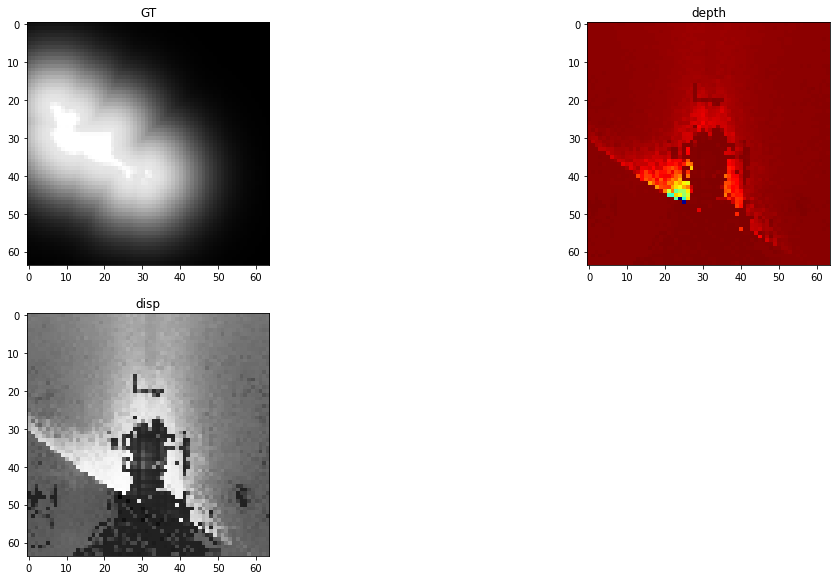

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09591794013977051
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


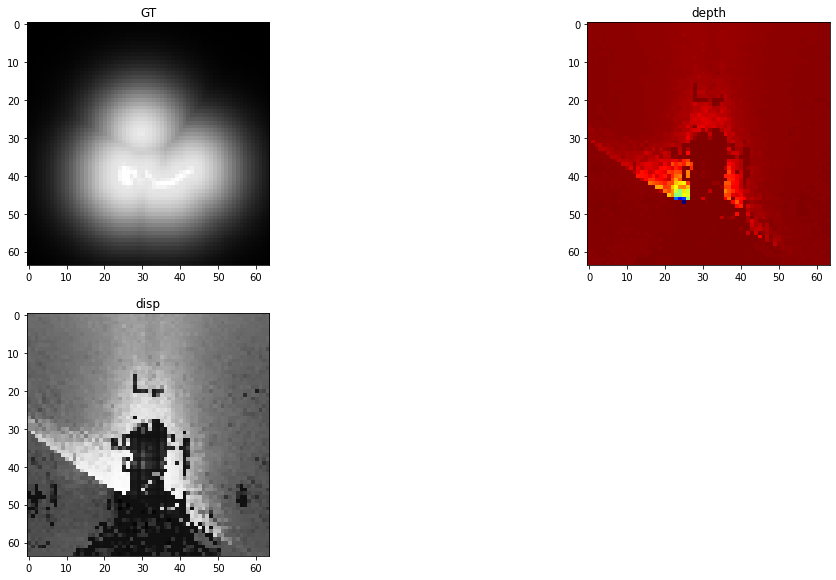

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09596967697143555
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


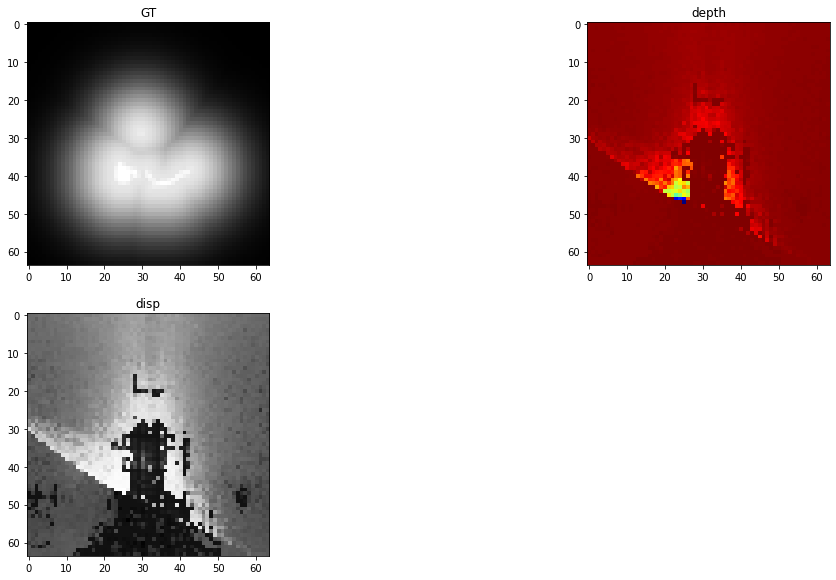

In [8]:
EPSILON = 1.0e-5
light_results = f(dataset.light_rays.cuda())
for i in range (len(dataset)):
    sample = dataset[i]
    print(sample.keys())
    # raise
    rays = sample['rays'].cuda()
    t = time.time()
    results = f(rays)
    torch.cuda.synchronize()
    print(time.time()-t)
    sm = efficient_sm(sample['pixels'].cuda(), dataset.light_pixels.cuda(),
                            results, light_results, 
                            sample['ppc'], dataset.light_ppc, 
                            image_shape=img_wh,  
                            fine_sampling=True, 
                            Light_N_importance=True, 
                            shadow_method='shadow_method_1')
    img_gt = torch.tensor(sample['rgbs']).view(img_wh[1], img_wh[0], 3)
#     print(sm.keys())
#     raise
    sm_pred = sm['rgb_fine'].cpu().view(img_wh[1], img_wh[0], 3)#.numpy()
    print(sm_pred.min(), sm_pred.max())
    depth_pred = sm['depth_fine'].view(img_wh[1], img_wh[0])
    depth = visualize_depth(depth_pred).permute(1,2,0)
    disp = 1/(depth_pred + EPSILON)
#     disp = visualize_depth(disp).permute(1,2,0) //
    print(disp.shape)
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(221)
    plt.title('GT')
    plt.imshow(img_gt)
    plt.subplot(222)
    plt.title('depth')
    plt.imshow(depth)
    plt.subplot(223)
    plt.title('disp')
    plt.imshow(disp.cpu().numpy(), cmap='Greys')
    plt.show()

In [9]:
trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.Tensor(np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])) @ c2w
    return c2w

In [28]:
render_poses = torch.stack([pose_spherical(angle, -30., 10.0) for angle in np.linspace(-180,180,40+1)[:-1]], 0)



tensor([[ 1.0000e+00,  6.1232e-17, -1.0606e-16, -1.0606e-15],
        [-1.2246e-16,  5.0000e-01, -8.6603e-01, -8.6603e+00],
        [ 0.0000e+00,  8.6603e-01,  5.0000e-01,  5.0000e+00]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.10361957550048828
torch.Size([64, 64])


/home/gridsan/ktiwary/.conda/envs/nerf_pl/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


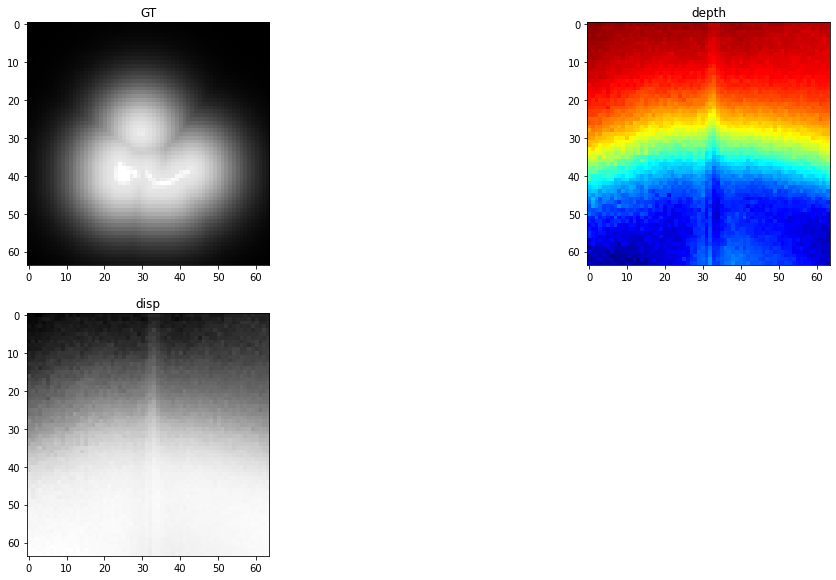

tensor([[ 0.9877,  0.0782, -0.1355, -1.3548],
        [-0.1564,  0.4938, -0.8554, -8.5536],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.1035454273223877
torch.Size([64, 64])


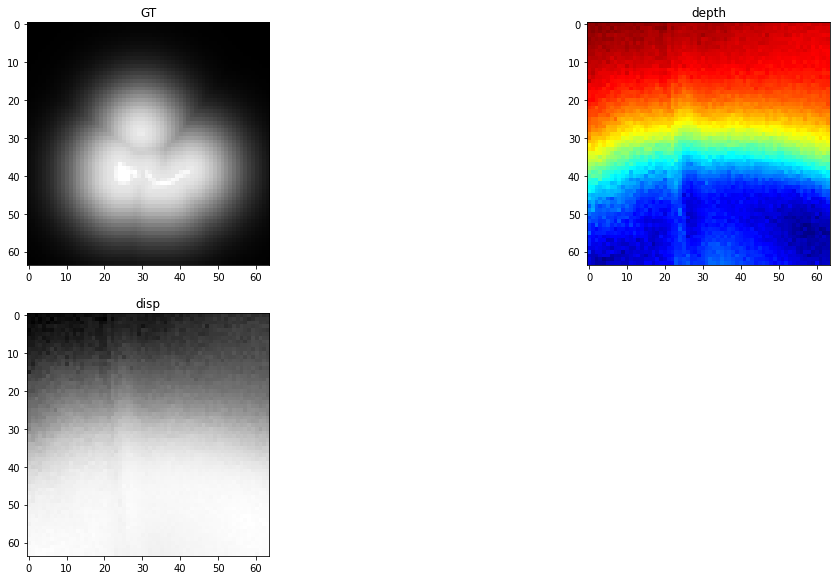

tensor([[ 0.9511,  0.1545, -0.2676, -2.6762],
        [-0.3090,  0.4755, -0.8236, -8.2364],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09769868850708008
torch.Size([64, 64])


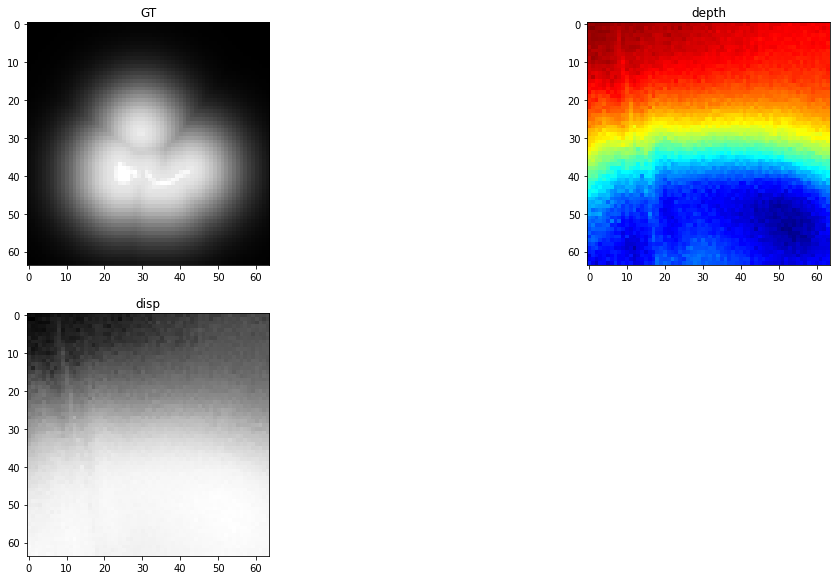

tensor([[ 0.8910,  0.2270, -0.3932, -3.9317],
        [-0.4540,  0.4455, -0.7716, -7.7163],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.0971517562866211
torch.Size([64, 64])


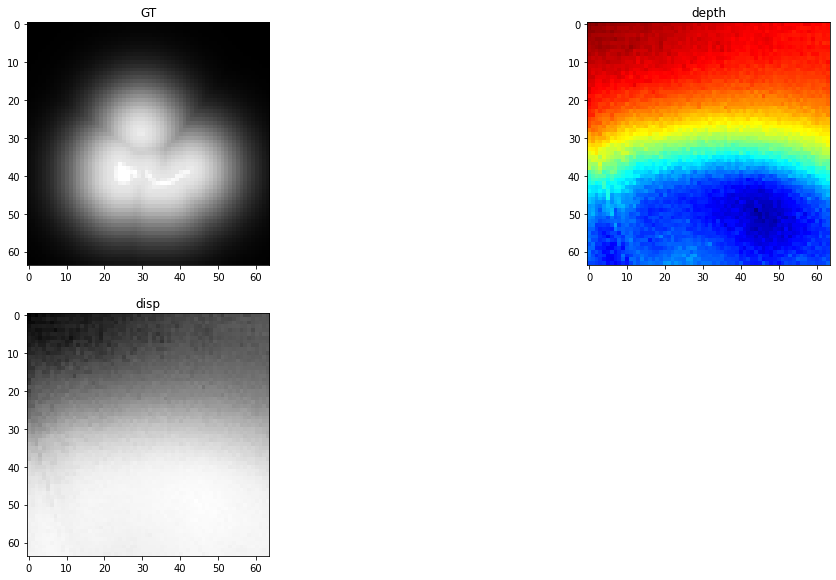

tensor([[ 0.8090,  0.2939, -0.5090, -5.0904],
        [-0.5878,  0.4045, -0.7006, -7.0063],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09591245651245117
torch.Size([64, 64])


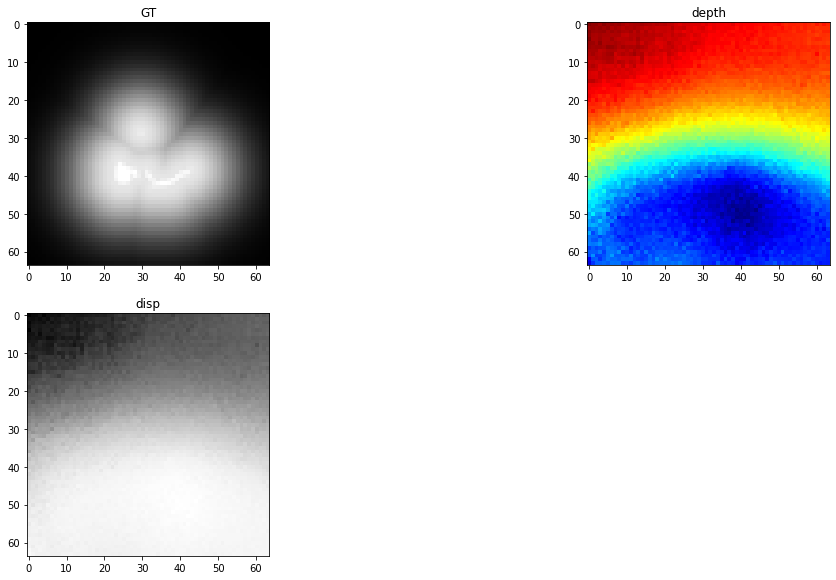

tensor([[ 0.7071,  0.3536, -0.6124, -6.1237],
        [-0.7071,  0.3536, -0.6124, -6.1237],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.0958859920501709
torch.Size([64, 64])


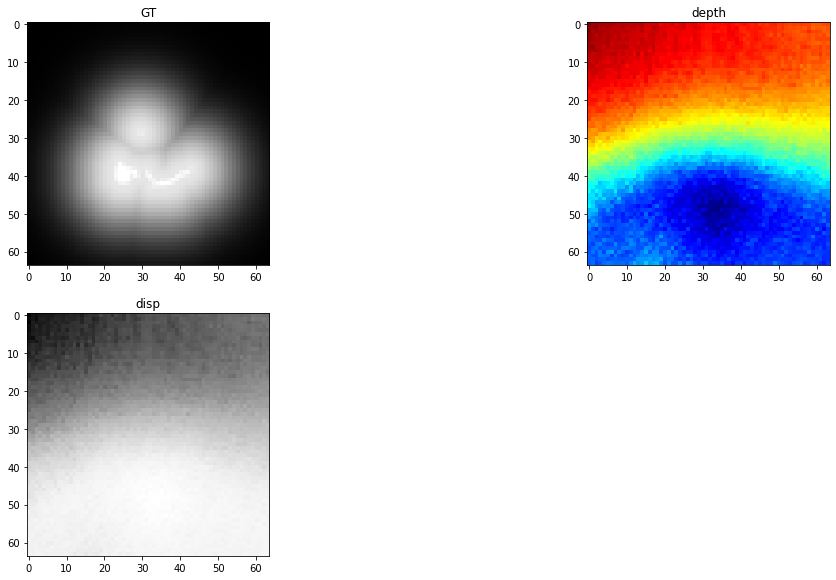

tensor([[ 0.5878,  0.4045, -0.7006, -7.0063],
        [-0.8090,  0.2939, -0.5090, -5.0904],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09590864181518555
torch.Size([64, 64])


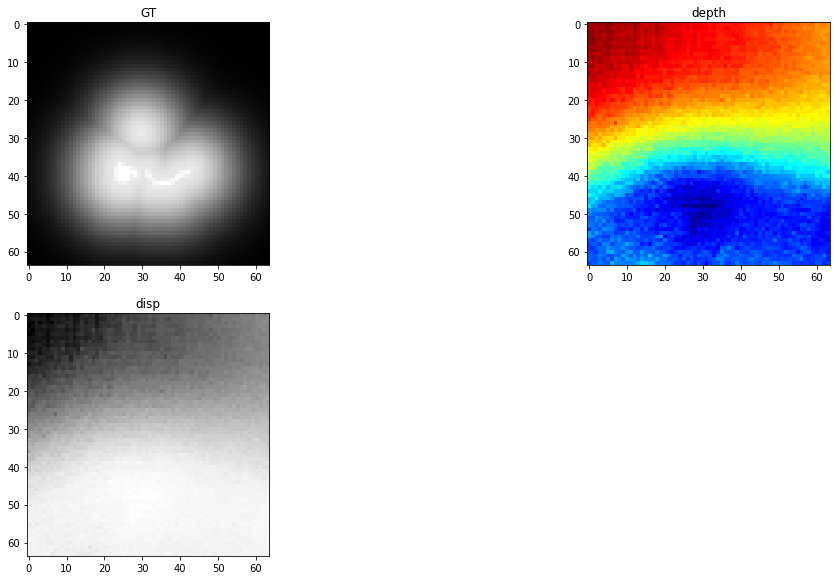

tensor([[ 0.4540,  0.4455, -0.7716, -7.7163],
        [-0.8910,  0.2270, -0.3932, -3.9317],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09576249122619629
torch.Size([64, 64])


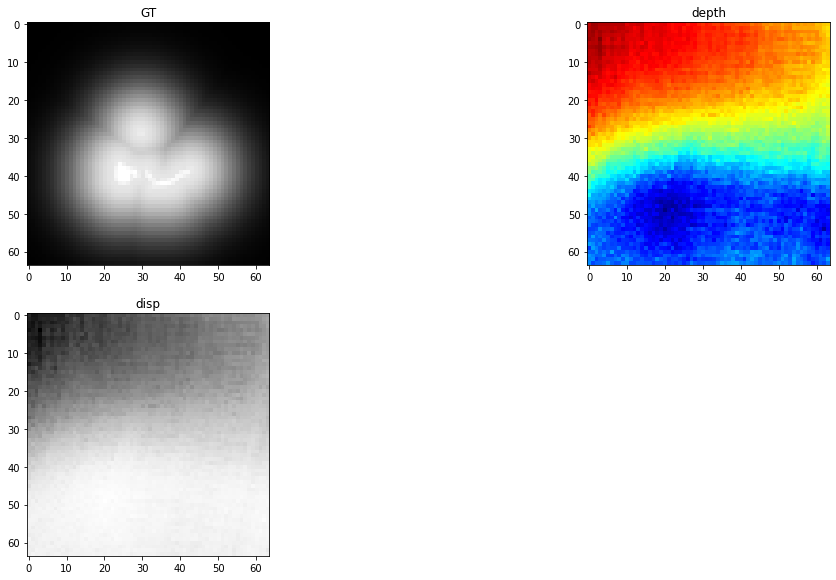

tensor([[ 0.3090,  0.4755, -0.8236, -8.2364],
        [-0.9511,  0.1545, -0.2676, -2.6762],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.0957329273223877
torch.Size([64, 64])


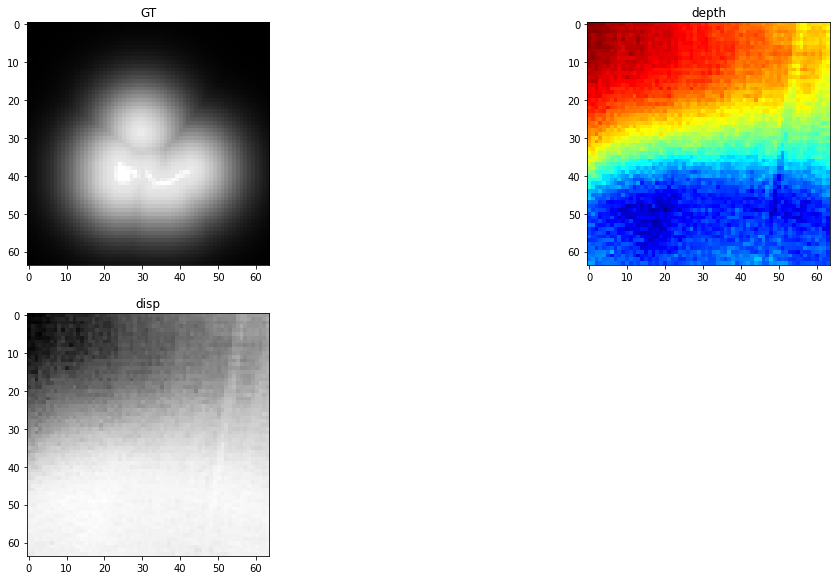

tensor([[ 0.1564,  0.4938, -0.8554, -8.5536],
        [-0.9877,  0.0782, -0.1355, -1.3548],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09580039978027344
torch.Size([64, 64])


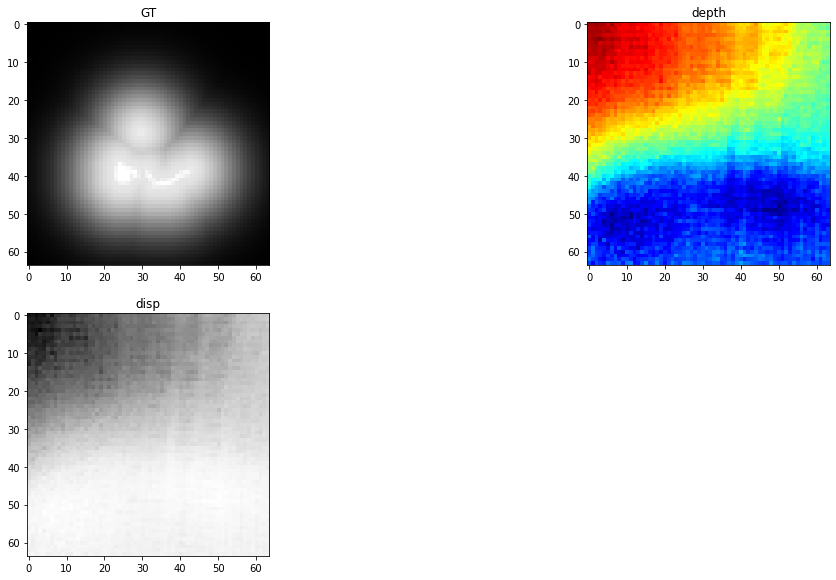

tensor([[-6.1232e-17,  5.0000e-01, -8.6603e-01, -8.6603e+00],
        [-1.0000e+00, -3.0616e-17,  5.3029e-17,  5.3029e-16],
        [ 0.0000e+00,  8.6603e-01,  5.0000e-01,  5.0000e+00]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09571290016174316
torch.Size([64, 64])


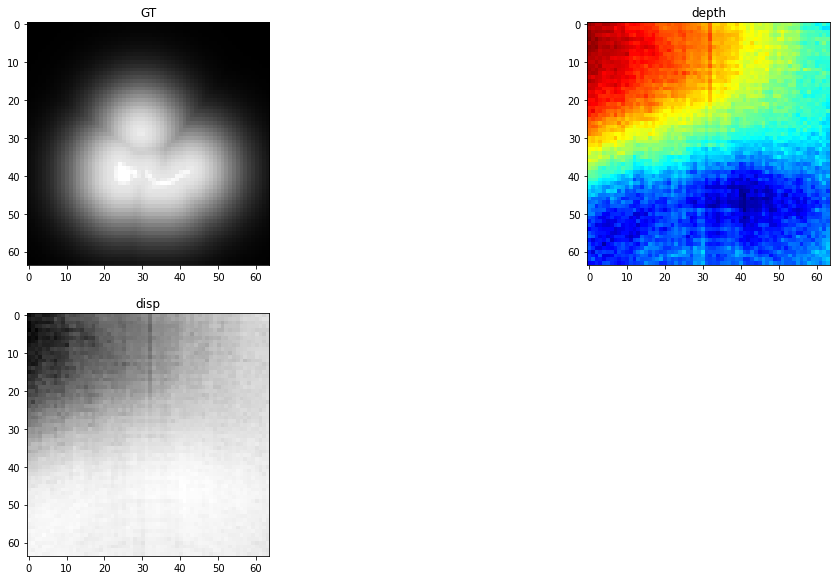

tensor([[-0.1564,  0.4938, -0.8554, -8.5536],
        [-0.9877, -0.0782,  0.1355,  1.3548],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09565353393554688
torch.Size([64, 64])


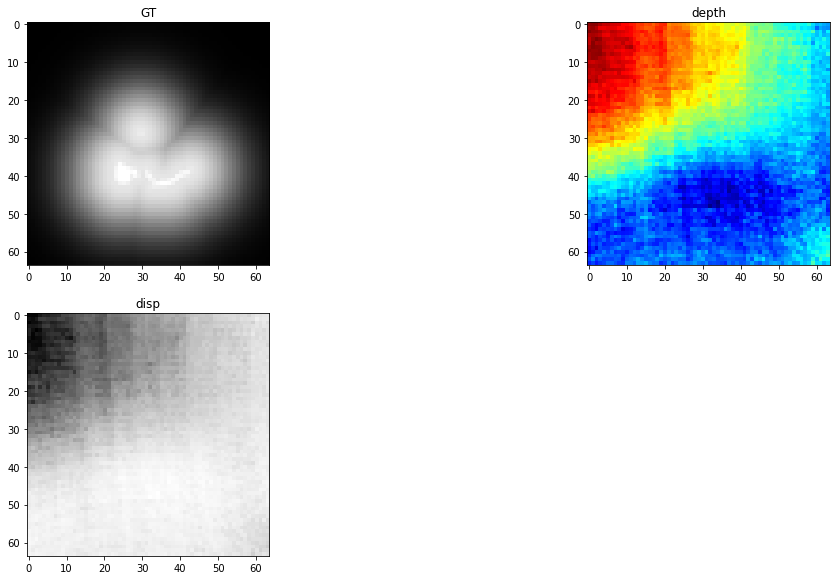

tensor([[-0.3090,  0.4755, -0.8236, -8.2364],
        [-0.9511, -0.1545,  0.2676,  2.6762],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09572696685791016
torch.Size([64, 64])


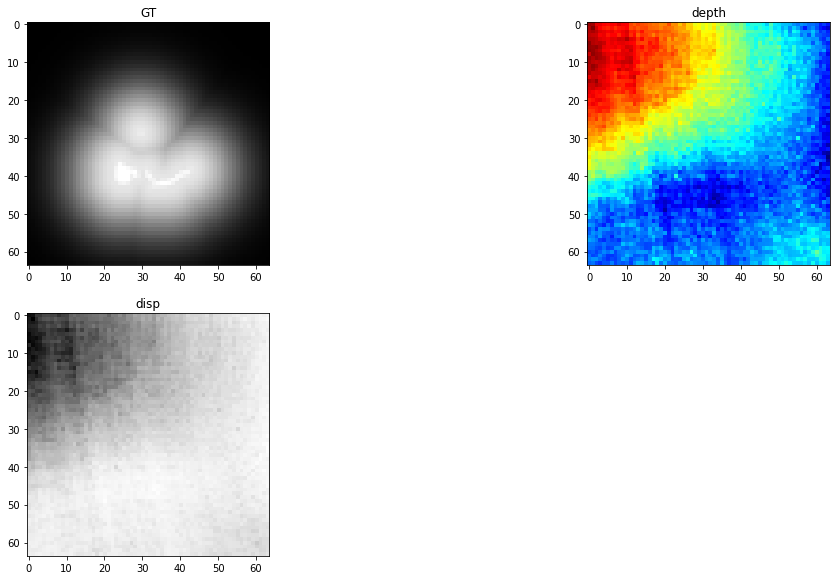

tensor([[-0.4540,  0.4455, -0.7716, -7.7163],
        [-0.8910, -0.2270,  0.3932,  3.9317],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09574389457702637
torch.Size([64, 64])


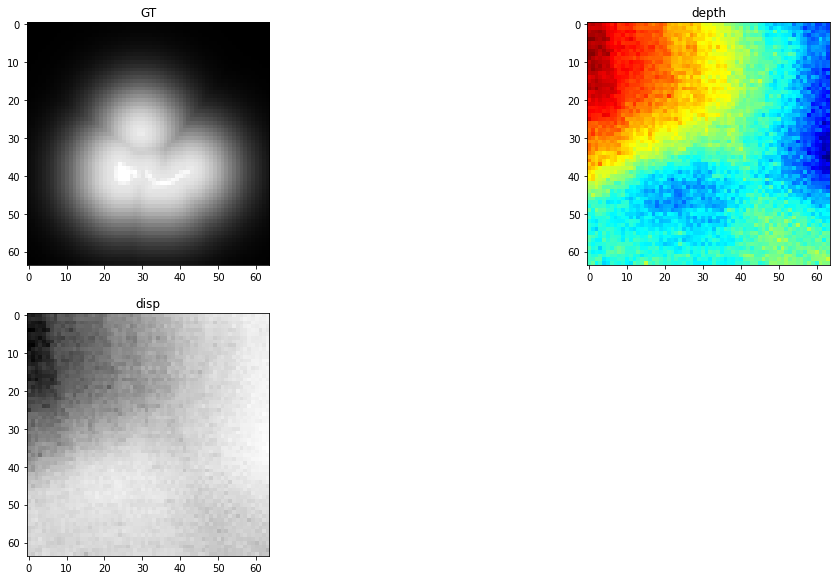

tensor([[-0.5878,  0.4045, -0.7006, -7.0063],
        [-0.8090, -0.2939,  0.5090,  5.0904],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09579706192016602
torch.Size([64, 64])


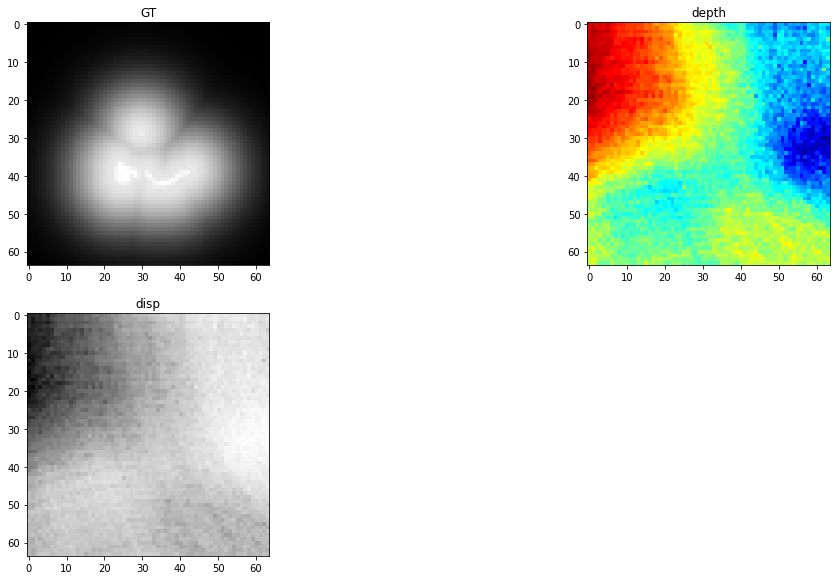

tensor([[-0.7071,  0.3536, -0.6124, -6.1237],
        [-0.7071, -0.3536,  0.6124,  6.1237],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.0959465503692627
torch.Size([64, 64])


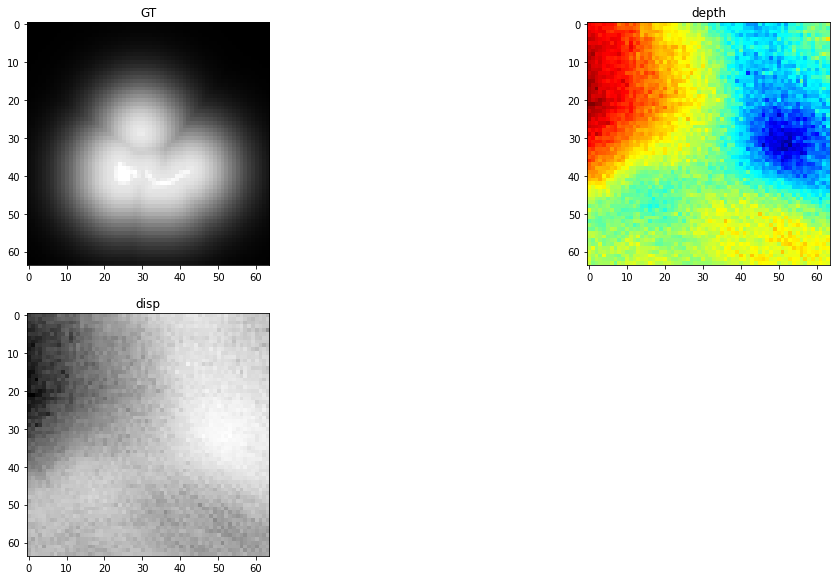

tensor([[-0.8090,  0.2939, -0.5090, -5.0904],
        [-0.5878, -0.4045,  0.7006,  7.0063],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09575605392456055
torch.Size([64, 64])


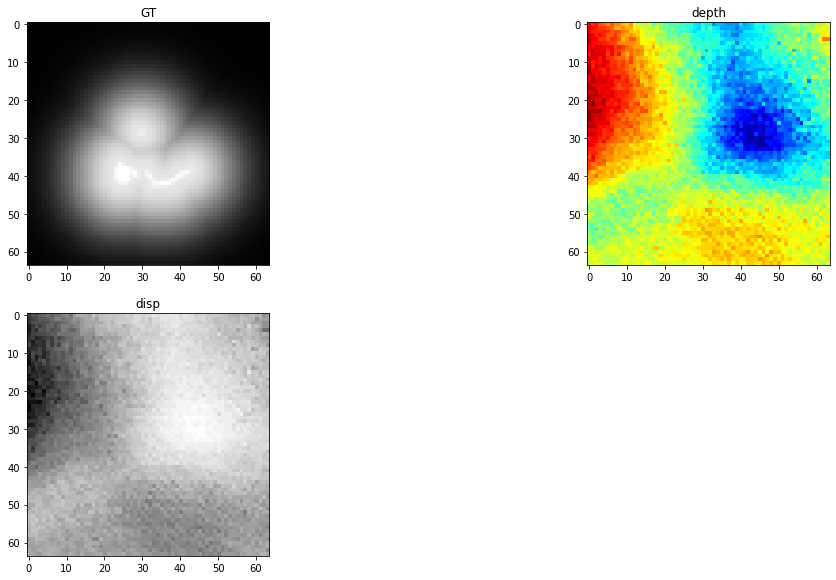

tensor([[-0.8910,  0.2270, -0.3932, -3.9317],
        [-0.4540, -0.4455,  0.7716,  7.7163],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09595751762390137
torch.Size([64, 64])


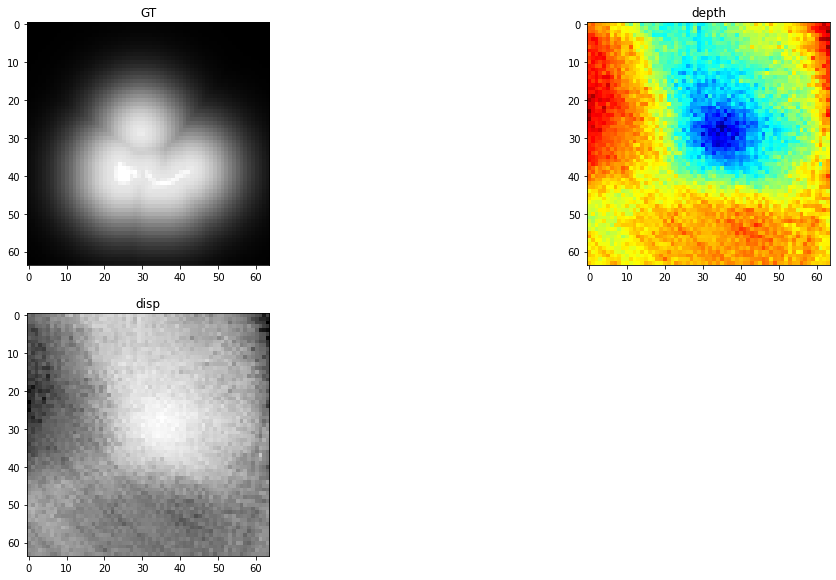

tensor([[-0.9511,  0.1545, -0.2676, -2.6762],
        [-0.3090, -0.4755,  0.8236,  8.2364],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09586524963378906
torch.Size([64, 64])


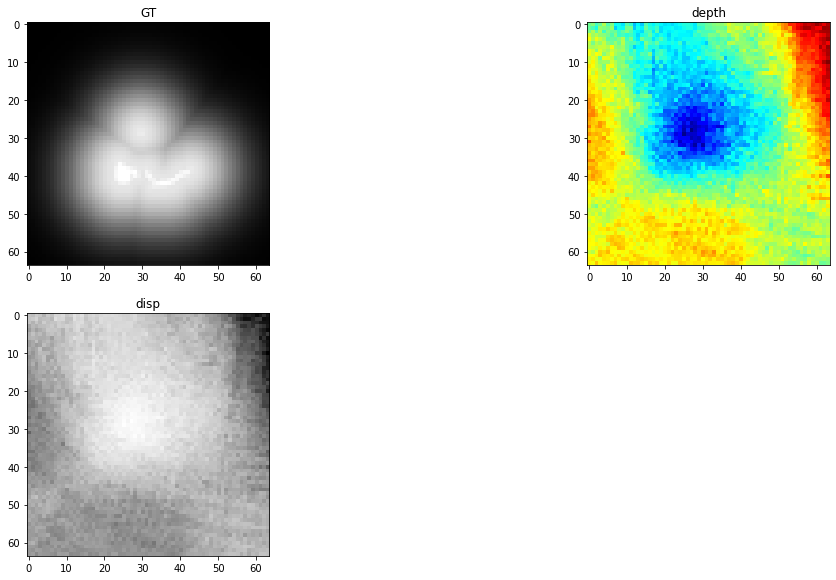

tensor([[-0.9877,  0.0782, -0.1355, -1.3548],
        [-0.1564, -0.4938,  0.8554,  8.5536],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09600472450256348
torch.Size([64, 64])


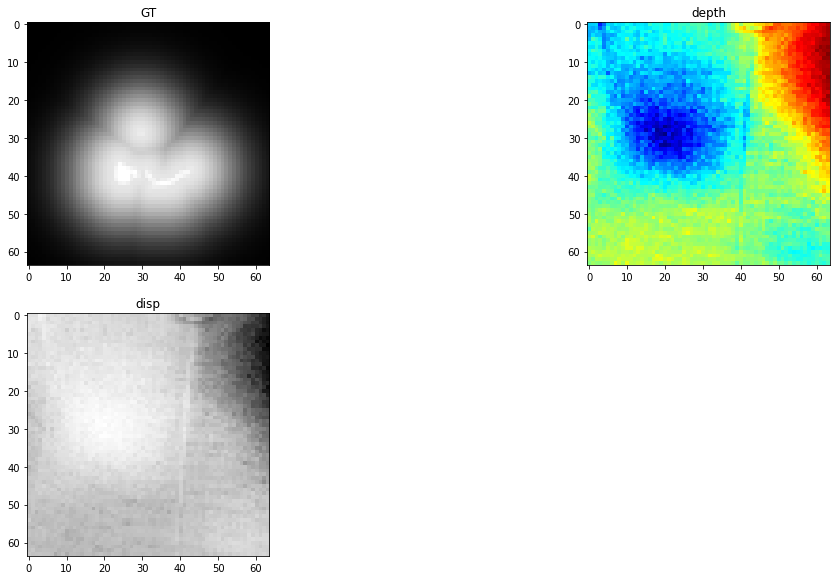

tensor([[-1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.5000,  0.8660,  8.6603],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09576034545898438
torch.Size([64, 64])


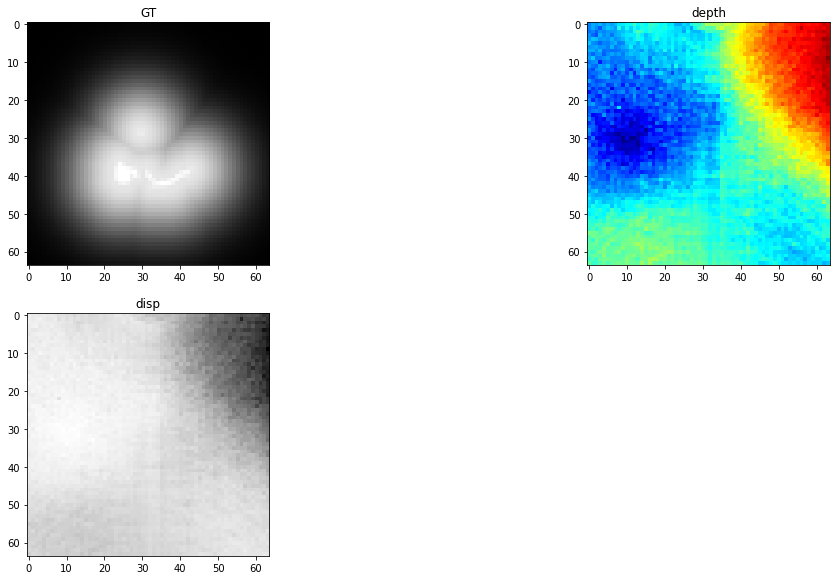

tensor([[-0.9877, -0.0782,  0.1355,  1.3548],
        [ 0.1564, -0.4938,  0.8554,  8.5536],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09580755233764648
torch.Size([64, 64])


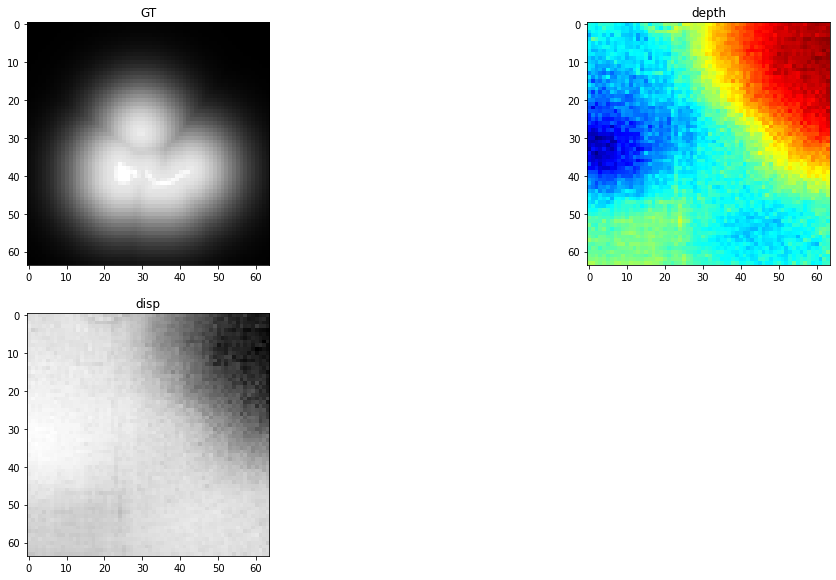

tensor([[-0.9511, -0.1545,  0.2676,  2.6762],
        [ 0.3090, -0.4755,  0.8236,  8.2364],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09584736824035645
torch.Size([64, 64])


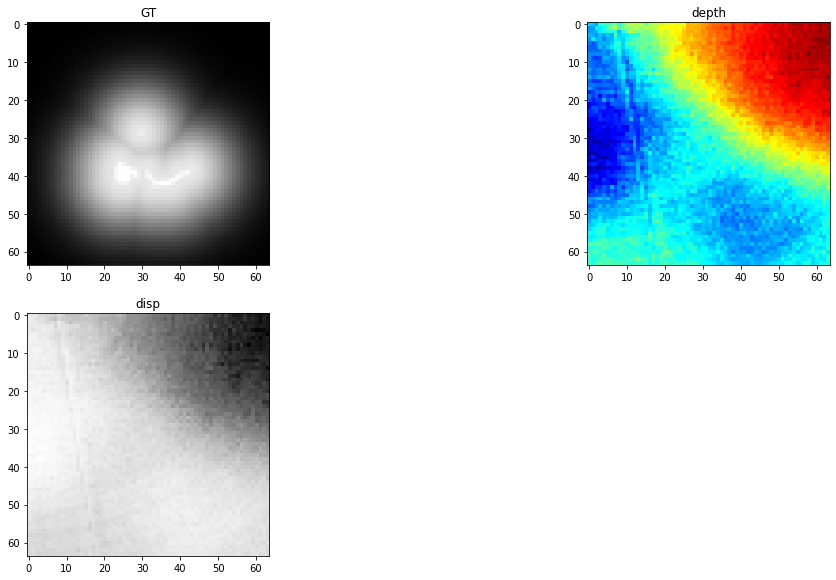

tensor([[-0.8910, -0.2270,  0.3932,  3.9317],
        [ 0.4540, -0.4455,  0.7716,  7.7163],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.0958402156829834
torch.Size([64, 64])


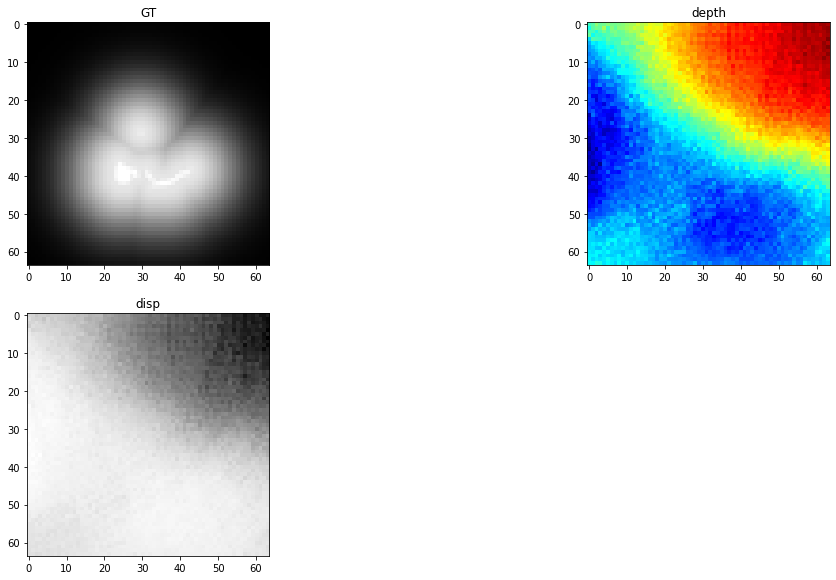

tensor([[-0.8090, -0.2939,  0.5090,  5.0904],
        [ 0.5878, -0.4045,  0.7006,  7.0063],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.0959324836730957
torch.Size([64, 64])


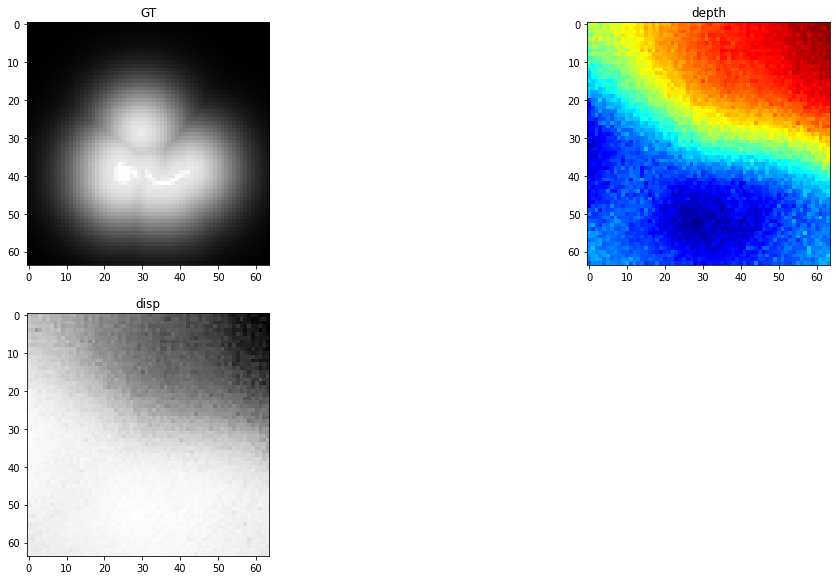

tensor([[-0.7071, -0.3536,  0.6124,  6.1237],
        [ 0.7071, -0.3536,  0.6124,  6.1237],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09589314460754395
torch.Size([64, 64])


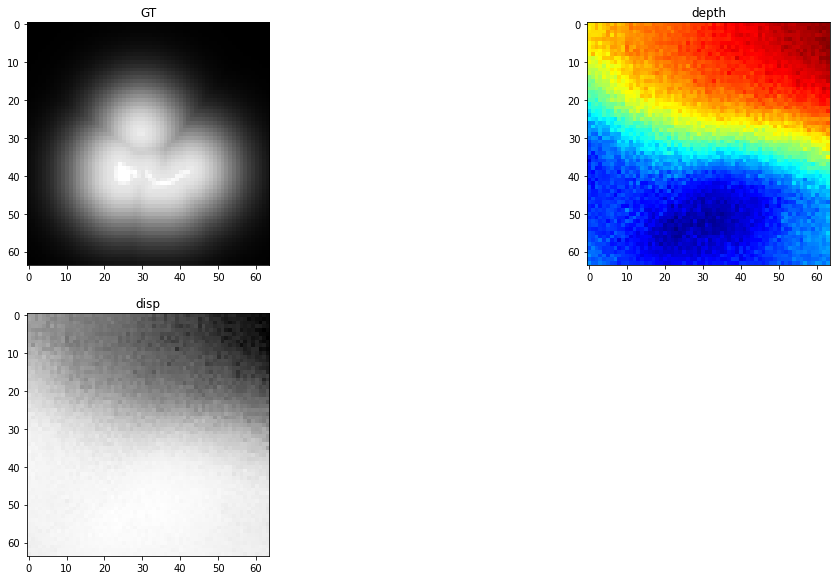

tensor([[-0.5878, -0.4045,  0.7006,  7.0063],
        [ 0.8090, -0.2939,  0.5090,  5.0904],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.0958547592163086
torch.Size([64, 64])


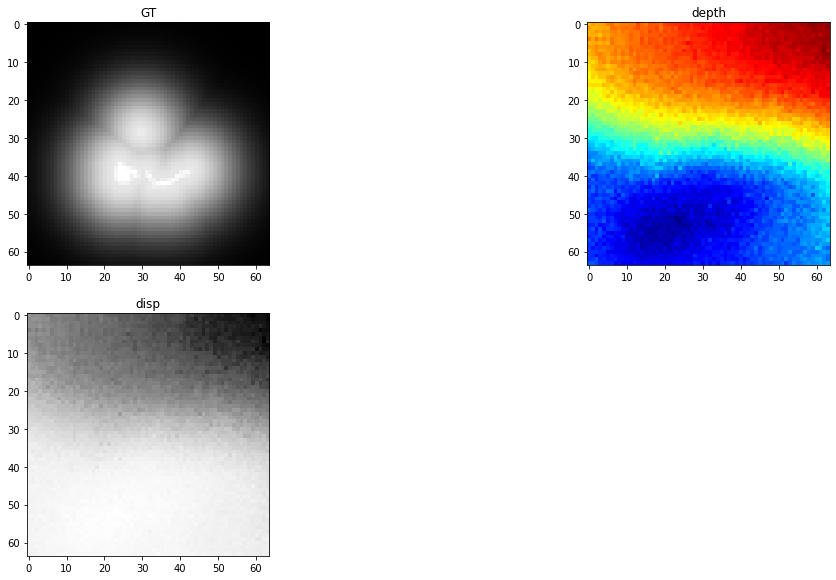

tensor([[-0.4540, -0.4455,  0.7716,  7.7163],
        [ 0.8910, -0.2270,  0.3932,  3.9317],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09589457511901855
torch.Size([64, 64])


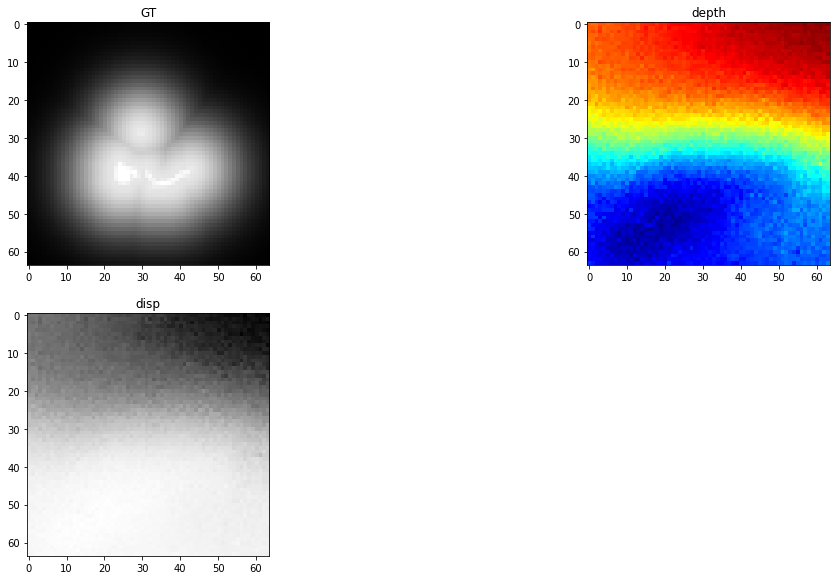

tensor([[-0.3090, -0.4755,  0.8236,  8.2364],
        [ 0.9511, -0.1545,  0.2676,  2.6762],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09575152397155762
torch.Size([64, 64])


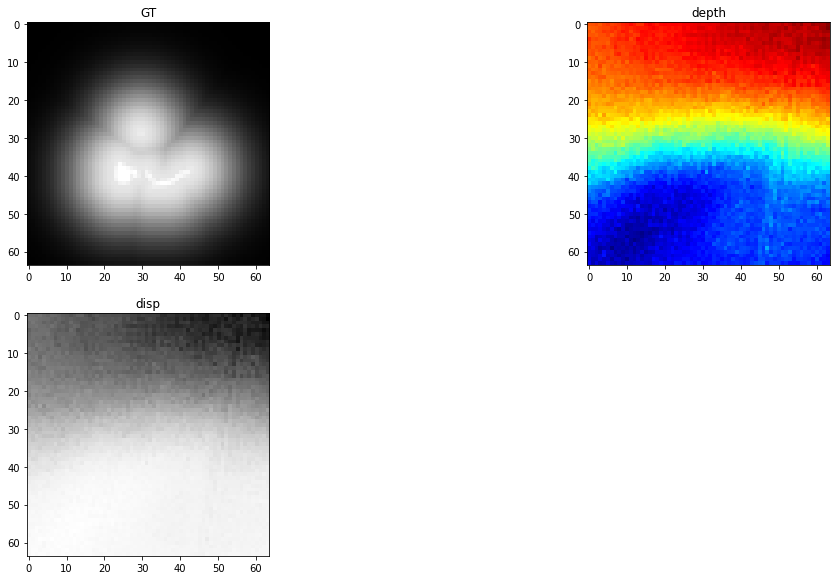

tensor([[-0.1564, -0.4938,  0.8554,  8.5536],
        [ 0.9877, -0.0782,  0.1355,  1.3548],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.0957646369934082
torch.Size([64, 64])


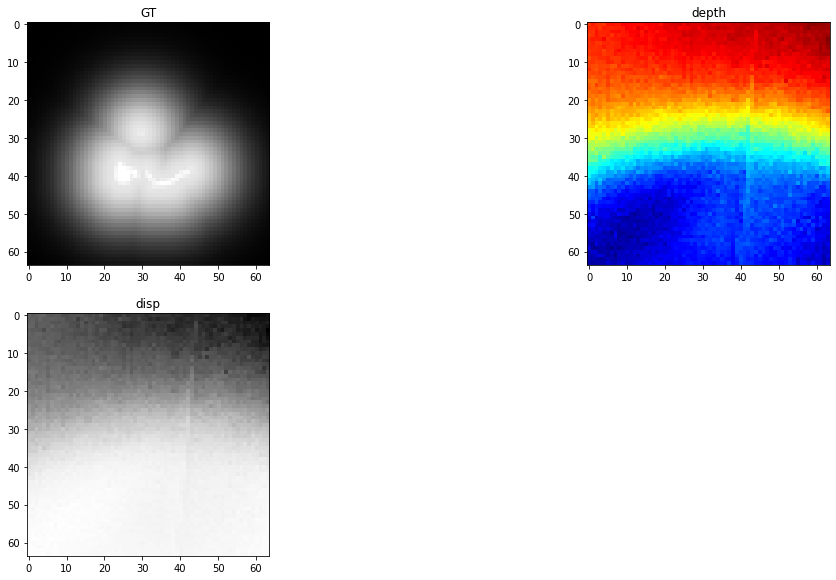

tensor([[-6.1232e-17, -5.0000e-01,  8.6603e-01,  8.6603e+00],
        [ 1.0000e+00, -3.0616e-17,  5.3029e-17,  5.3029e-16],
        [ 0.0000e+00,  8.6603e-01,  5.0000e-01,  5.0000e+00]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09576630592346191
torch.Size([64, 64])


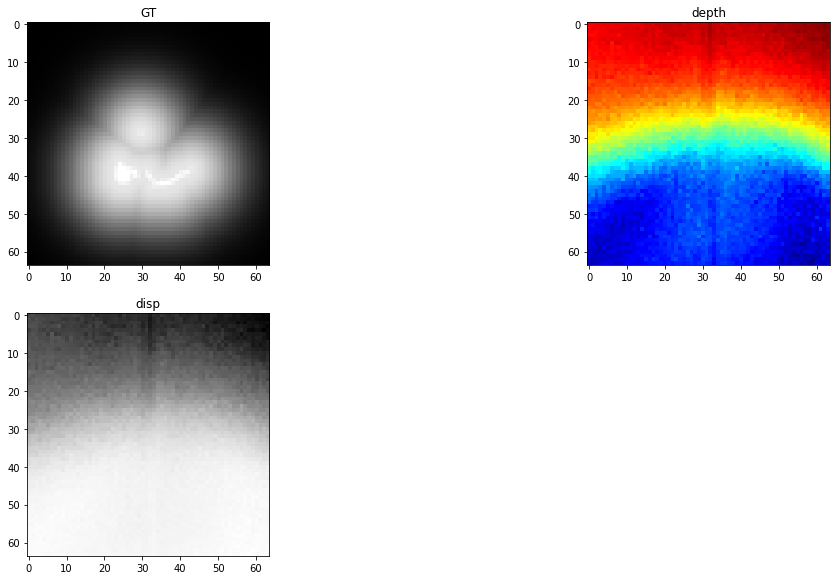

tensor([[ 0.1564, -0.4938,  0.8554,  8.5536],
        [ 0.9877,  0.0782, -0.1355, -1.3548],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09568977355957031
torch.Size([64, 64])


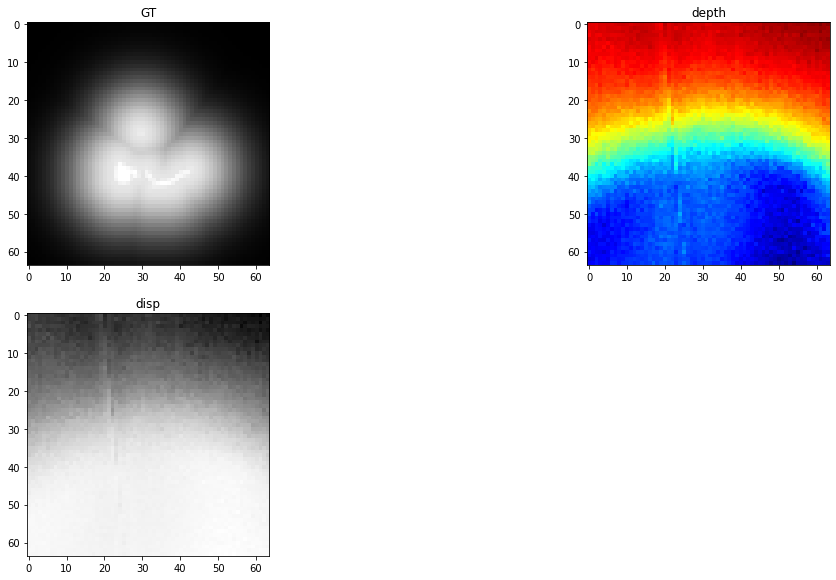

tensor([[ 0.3090, -0.4755,  0.8236,  8.2364],
        [ 0.9511,  0.1545, -0.2676, -2.6762],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09596085548400879
torch.Size([64, 64])


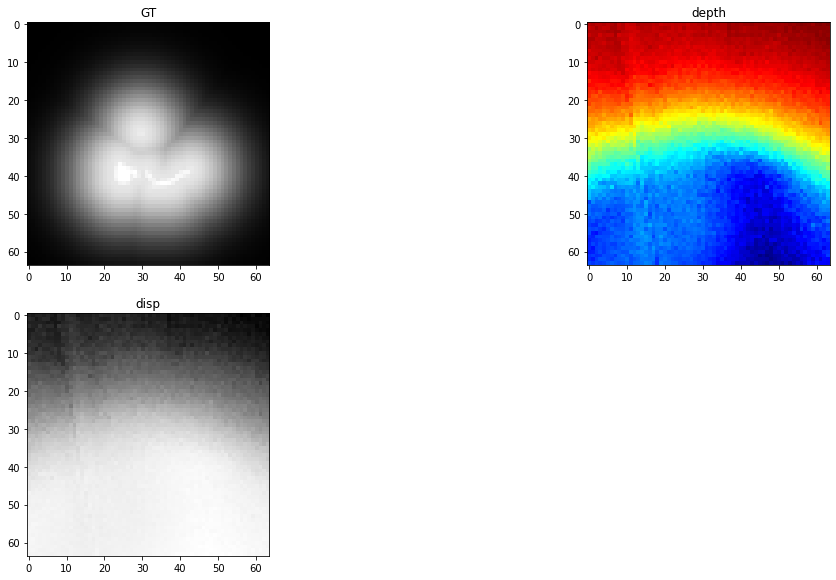

tensor([[ 0.4540, -0.4455,  0.7716,  7.7163],
        [ 0.8910,  0.2270, -0.3932, -3.9317],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.0958716869354248
torch.Size([64, 64])


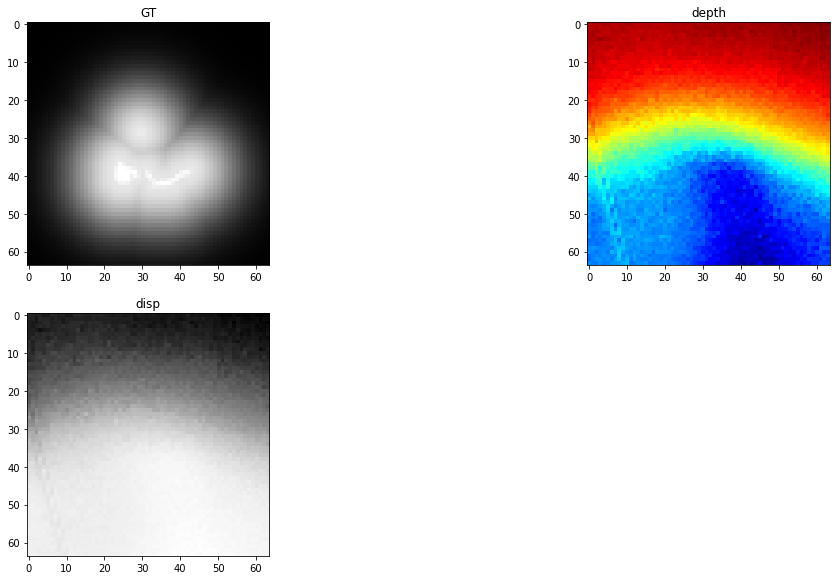

tensor([[ 0.5878, -0.4045,  0.7006,  7.0063],
        [ 0.8090,  0.2939, -0.5090, -5.0904],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09584283828735352
torch.Size([64, 64])


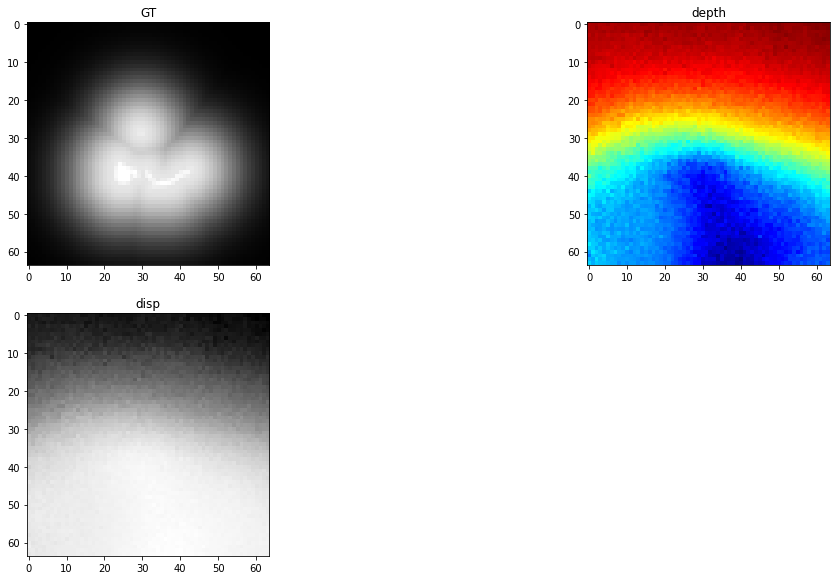

tensor([[ 0.7071, -0.3536,  0.6124,  6.1237],
        [ 0.7071,  0.3536, -0.6124, -6.1237],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09565353393554688
torch.Size([64, 64])


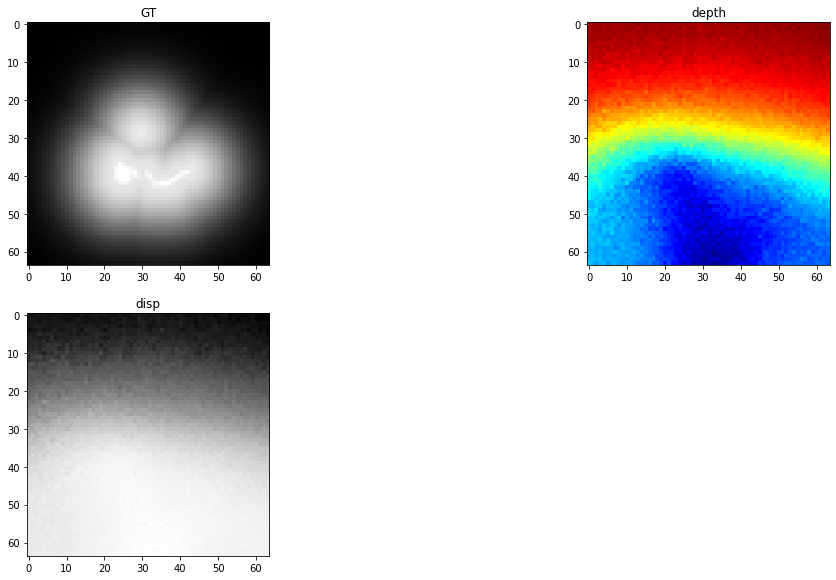

tensor([[ 0.8090, -0.2939,  0.5090,  5.0904],
        [ 0.5878,  0.4045, -0.7006, -7.0063],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09555315971374512
torch.Size([64, 64])


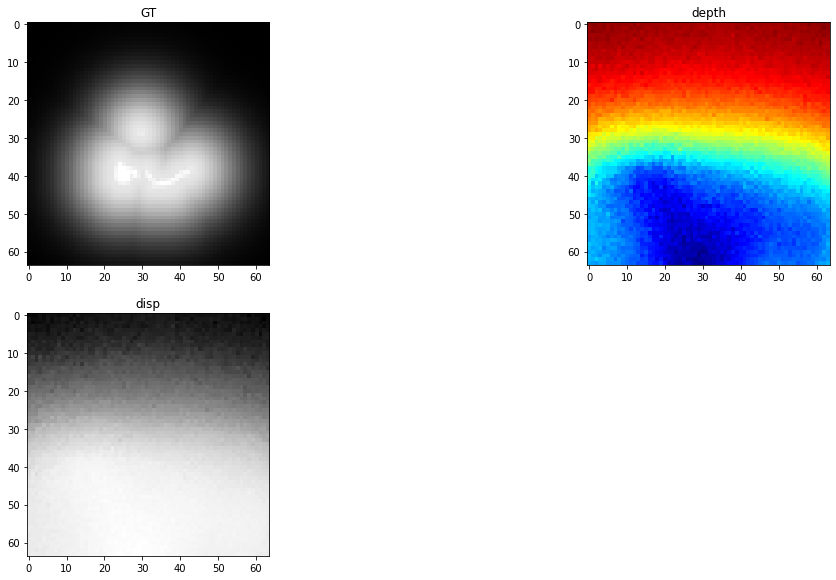

tensor([[ 0.8910, -0.2270,  0.3932,  3.9317],
        [ 0.4540,  0.4455, -0.7716, -7.7163],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.0954427719116211
torch.Size([64, 64])


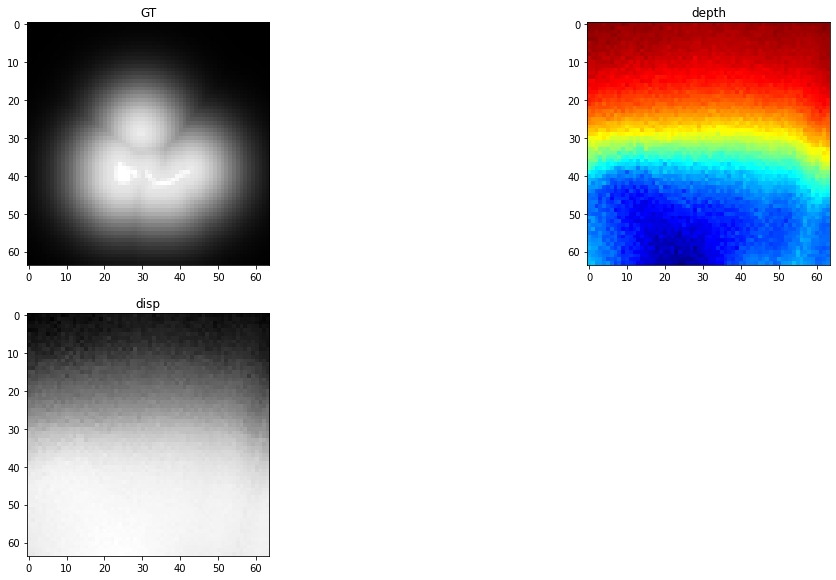

tensor([[ 0.9511, -0.1545,  0.2676,  2.6762],
        [ 0.3090,  0.4755, -0.8236, -8.2364],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.09549999237060547
torch.Size([64, 64])


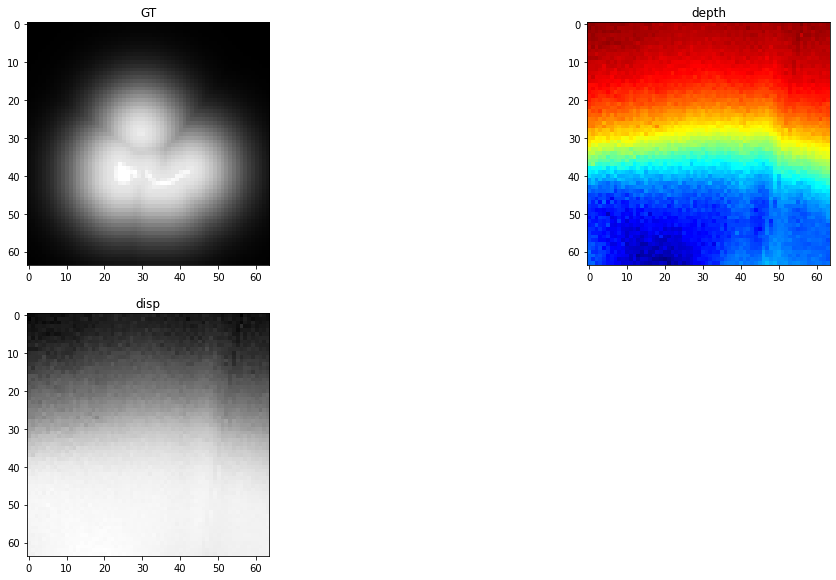

tensor([[ 0.9877, -0.0782,  0.1355,  1.3548],
        [ 0.1564,  0.4938, -0.8554, -8.5536],
        [ 0.0000,  0.8660,  0.5000,  5.0000]])
dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.0956878662109375
torch.Size([64, 64])


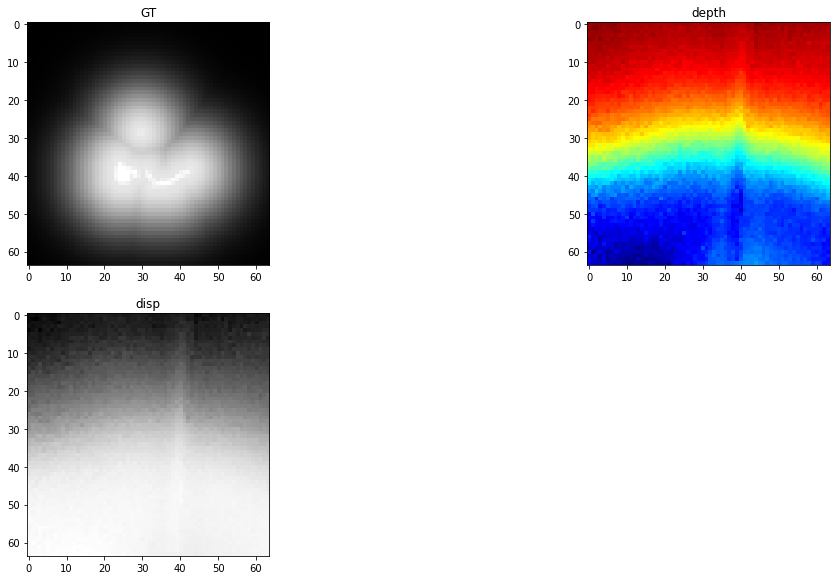

In [29]:
for p in range (render_poses.shape[0]):
    c2w = render_poses[p][:3, :4]
    print(c2w)
    hfov = dataset.meta['camera_angle_x'] * 180./np.pi
#     ppc = Camera(hfov, (h, w))
#     ppc.set_pose_using_blender_matrix(c2w, False)
#     all_ppc.extend([ppc]*h*w)
    rays_o, rays_d = get_rays(dataset.directions, c2w)
    rays = torch.cat([rays_o, rays_d, 
                      dataset.near*torch.ones_like(rays_o[:, :1]),
                      dataset.far*torch.ones_like(rays_o[:, :1])],
                      1) # (H*W, 8)
    print(sample.keys())
    # raise
    rays = rays.cuda()
#     rays = sample['rays'].cuda()


    t = time.time()
    results = f(rays)
    torch.cuda.synchronize()
    print(time.time()-t)
    img_gt = torch.tensor(sample['rgbs']).view(img_wh[1], img_wh[0], 3)
    depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])
    disp = 1/(depth_pred + EPSILON)
    disp = normalize_min_max(disp)
    print(disp.shape)
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(221)
    plt.title('GT')
    plt.imshow(img_gt)
    plt.subplot(222)
    plt.title('depth')
    plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
    plt.subplot(223)
    plt.title('disp')
    plt.imshow(disp.cpu().numpy(), cmap='Greys')
    plt.show()



In [1]:
trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.Tensor(np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])) @ c2w
    return c2w